In [1]:
import matplotlib.pyplot as plt

from oceanoi.oijax import OptimalInterpJax as OptimalInterp
import jax.numpy as jnp

# from oceanoi.oiscipy import OptimalInterpScipy as OptimalInterp
# import numpy as jnp

from jax import random as jrandom
import jax.scipy.linalg as jla
import jax

In [2]:
%matplotlib notebook

In [18]:
from functools import partial
@partial(jax.jit, static_argnums=3) 
def sum_spectral_mixture_kernel(x, xpr, params, nf):
    print(nf)
    eta, l, T = params[0:nf], params[nf:nf+nf], params[nf+nf:]
    K = spectral_mixture_kernel(x, xpr, (eta[0], l[0], T[0]))
    for ii in range(1,nf):
        K += spectral_mixture_kernel(x, xpr, (eta[ii], l[ii], T[ii]))
    return K
    
def spectral_mixture_kernel(x, xpr, params):
    eta, l, T = params
    return eta*eta * expquad(x, xpr, l)*cosine(x, xpr, T)

def cosine(x,xpr,l):
    return jnp.cos(2*jnp.pi*jnp.abs(x-xpr)/(l*l))

def expquad(x, xpr, l):
    return jnp.exp(-(x-xpr)*(x-xpr)/(2*l*l))



# Mean functions
def harmonic_pred(Aa, Ba, omega, t):
    nomega = len(omega)
    amp = t * 0.0
    for ii in range(nomega):
        amp += Aa[ii]*jnp.cos(omega[ii]*t) + Ba[ii]*jnp.sin(omega[ii]*t)
    return amp

def harmonic_mean(x, mean_params, omega=()):
    nomega = len(omega)
    Aa = mean_params[0:nomega]
    Ba = mean_params[nomega:]
    return harmonic_pred(Aa, Ba, omega, x)


In [19]:
twopi = 2*jnp.pi
T_M2 = 12.42
T_M4 = 12.42/2
T_M6 = 12.42/3

T_S2 = 12.00

2


<IPython.core.display.Javascript object>


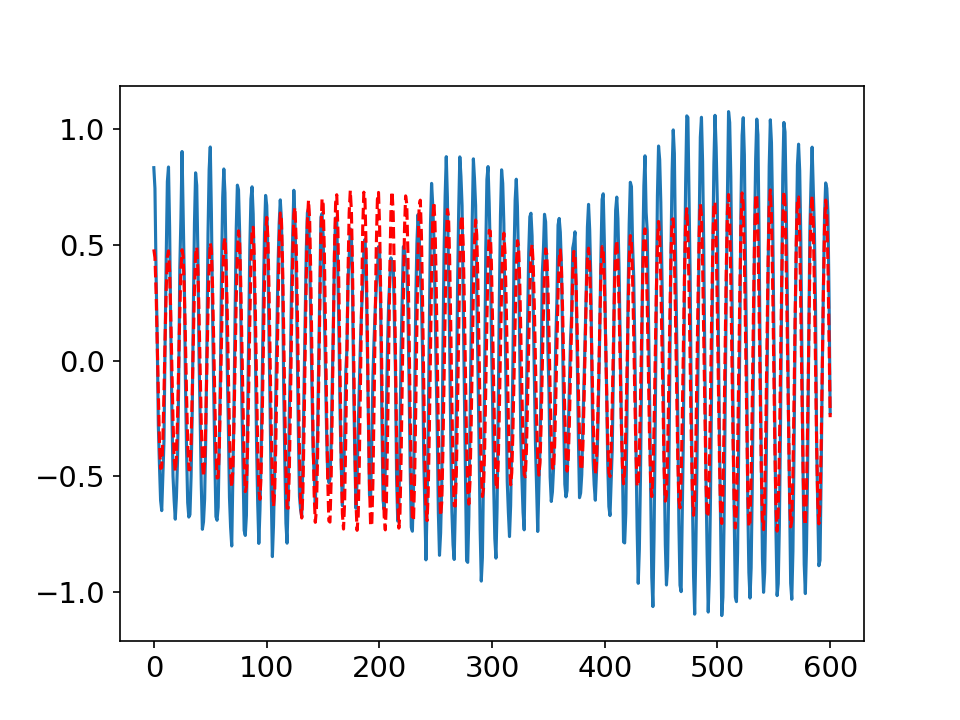

CPU times: user 183 ms, sys: 108 ms, total: 291 ms
Wall time: 133 ms


In [20]:
%%time
#####
# Define the parameters for the mean and covariance function (we hope to estimate these later...)
# covfunc = spectral_mixture_kernel
# covparams = (0.2, 100., jnp.sqrt(T_M4))
# cov_kwargs = {}

covfunc = sum_spectral_mixture_kernel
covparams = (0.2, 0.05, 60., 20., jnp.sqrt(T_M2), jnp.sqrt(T_M4))
cov_kwargs = {} #{'n':2}
cov_args=(2,)

meanfunc = harmonic_mean
meanparams = ( 0.6, -0.12, 0.1, -0.05)
# meanparams = ( 0., 0., 0., 0.,)

omega = (twopi/(T_M2), twopi/(T_S2))

noise = 0.02

T = 25*24 # Length of the domain [hours]
N = 25*24 # Number of data points

#####
# print(omega, twopi/12.42/24)

x = jnp.linspace(0, T, N)[:,None]
dx = T/N

OI = OptimalInterp(x, x, noise, covfunc, covparams,
            mean_func=meanfunc, mean_params=meanparams,
            mean_kwargs=dict(omega=omega),
            cov_kwargs=cov_kwargs, cov_args=cov_args
            )

# This will return a dask array
y_d = OI.prior(noise=noise)

plt.plot(x, y_d,'-',)

plt.plot(x, OI.mu_d,'r--',)

In [21]:
omega

(0.5058925368099506, 0.5235987755982988)

In [22]:
import optax
from time import time

# Optimise the covariance parameters only

In [26]:
%%time

# Try putting all the input parameters into one vector

# This is hard-wired to the case above
def build_gp(theta):
    covparams = (jnp.exp(theta[1]), jnp.exp(theta[2]), jnp.exp(theta[3]),
                jnp.exp(theta[4]), jnp.exp(theta[5]), jnp.exp(theta[6]))
    return OptimalInterp(x, x, jnp.exp(theta[0]), 
            covfunc, covparams, cov_args=cov_args, 
            mean_func=meanfunc, mean_params=meanparams, mean_kwargs=dict(omega=omega),)

@jax.jit
@jax.value_and_grad
def loss(theta):
    return -build_gp(theta).log_marg_likelihood(y_d)

params = jnp.array([jnp.log(0.01), jnp.log(1.), jnp.log(0.5), 
                    jnp.log(50), jnp.log(20),
                    jnp.log(jnp.sqrt(12)),jnp.log(jnp.sqrt(6))])

# opt = optax.sgd(learning_rate=3e-4)
opt = optax.adam(learning_rate=1e-3)

opt_state = opt.init(params)
for i in range(1000):
    loss_val, grads = loss(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 25 == 0:
        print(f'step {i}, loss: {loss_val}')
        print(jnp.exp(params))
    if loss_val < -5000:
        print(f'step {i}, loss: {loss_val}')
        break

print(jnp.exp(params[0]), noise)
print(jnp.exp(params[1]), covparams[0])
print(jnp.exp(params[2]), covparams[1])
print(jnp.exp(params[3]), covparams[2])

2
2
step 0, loss: 1553.5087171143798
[1.00100050e-02 9.99000500e-01 4.99500250e-01 4.99500250e+01
 1.99800100e+01 3.46756745e+00 2.45194046e+00]
step 25, loss: 1390.0602364703816
[1.02621577e-02 9.74437665e-01 4.86848731e-01 5.03484710e+01
 1.95211084e+01 3.48430660e+00 2.49844064e+00]
step 50, loss: 1254.0589734026566
[1.05156950e-02 9.51143780e-01 4.73822655e-01 5.03871416e+01
 1.91829383e+01 3.48679504e+00 2.50226822e+00]
step 75, loss: 1128.1661677872676
[1.07688087e-02 9.28223239e-01 4.61210329e-01 5.05110104e+01
 1.88748605e+01 3.48781982e+00 2.49484181e+00]
step 100, loss: 1011.9615872450353
[1.10211273e-02 9.05684324e-01 4.49020372e-01 5.06957592e+01
 1.85923470e+01 3.48850058e+00 2.48986796e+00]


KeyboardInterrupt: 

# Fix the SM kernel period

In [9]:
%%time

# Try putting all the input parameters into one vector

# This is hard-wired to the case above
def build_gp(theta):
    covparams = (jnp.exp(theta[1]), jnp.exp(theta[2]), jnp.sqrt(T_M4))
    return OptimalInterp(x, x, jnp.exp(theta[0]), 
            covfunc, covparams,
            mean_func=meanfunc, mean_params=meanparams, mean_kwargs=dict(omega=omega),)

@jax.jit
@jax.value_and_grad
def loss(theta):
    return -build_gp(theta).log_marg_likelihood(y_d)

params = jnp.array([jnp.log(0.1), jnp.log(1.), jnp.log(50)])

opt = optax.sgd(learning_rate=3e-4)
# opt = optax.adam(learning_rate=1e-3)

opt_state = opt.init(params)
for i in range(1000):
    loss_val, grads = loss(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 25 == 0:
        print(f'step {i}, loss: {loss_val}')
        print(jnp.exp(params))
    if loss_val < -5000:
        print(f'step {i}, loss: {loss_val}')
        break

print(jnp.exp(params[0]), noise)
print(jnp.exp(params[1]), covparams[0])
print(jnp.exp(params[2]), covparams[1])
# print(jnp.exp(params[3]), covparams[2])

TypeError: CompiledFunction object argument after * must be an iterable, not NoneType

# Estimate the mean function parameters

In [10]:
%%time

# Try putting all the input parameters into one vector

# This is hard-wired to the case above
def build_gp(theta):
    mycovparams = (jnp.exp(theta[1]), jnp.exp(theta[2]), jnp.sqrt(T_M4))
    mymeanparams = theta[3:]
    return OptimalInterp(x, x, jnp.exp(theta[0]), 
            covfunc, mycovparams,
            mean_func=meanfunc, mean_params=mymeanparams, mean_kwargs=dict(omega=omega),)

@jax.jit
@jax.value_and_grad
def loss(theta):
    return -build_gp(theta).log_marg_likelihood(y_d)

params = jnp.array([jnp.log(0.01), jnp.log(1.), jnp.log(50),
                   0.1,0.1, 0.1,0.1])

# opt = optax.sgd(learning_rate=3e-4)
opt = optax.adam(learning_rate=1e-2)

opt_state = opt.init(params)
for i in range(2000):
    loss_val, grads = loss(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 25 == 0:
        print(f'step {i}, loss: {loss_val}')
        print(jnp.exp(params[0:3]))
        print(params[3:])
    if loss_val < -5000:
        print(f'step {i}, loss: {loss_val}')
        break

print(jnp.exp(params[0]), noise)
print(jnp.exp(params[1]), covparams[0])
print(jnp.exp(params[2]), covparams[1])
print('Mean parameters:')
print(params[3:], meanparams)
# print(jnp.exp(params[3]), covparams[2])

TypeError: CompiledFunction object argument after * must be an iterable, not NoneType